# Even more efficient quantum computations of chemistry through tensor hypercontraction

The notebook implements the core block of the algorithm described in https://arxiv.org/pdf/2011.03494

In [1]:
import itertools
from typing import Iterator, Sequence

import numpy as np

from classiq import *
from classiq.interface.generator.model.preferences.preferences import (
    OptimizationLevel,
    TranspilationOption,
)
from classiq.qmod.qmod_variable import QVar
from classiq.qmod.symbolic import pi

## Variables Definition 

This section defines the variables used in the preprocessing code.  
All theoretical motivation, physical meaning, and algorithmic justification are given in the reference article; here, we **only document the role of each variable in the code**.

### Resolution and spin parameters

- **`N_EPSILON`**  
  Number of qubits used to represent the **quantum number resolution** of the result.  
  Controls numerical precision in state preparation and phase-dependent quantities.

- **`N_UD`**  
  Number of spin-orbitals per spin sector (up/down).

In [2]:
counter = itertools.count()

N_EPSILON = 4  # This should be 10
N_UD = 3  # This should be 54
n_mn = (3 * 2 * N_UD - 1).bit_length()
m = max(2**n_mn - 1, 2)
n_d = (N_UD + m * (m // 2) - 1).bit_length()
n_aleph = 14 + N_EPSILON
n_beth = N_EPSILON
n_t = N_EPSILON
t_max = max(2**n_t - 1, 2)
n_rot = n_beth * N_UD
# n_ell = 2 * n_mn + 4 + n_d + 1 + 2 * n_mn + 2 * n_aleph + 1
# n_psi = 2 * N_UD + 2

### Randomized preprocessing data

The following variables are **randomly generated placeholders** with the correct shapes and bit-widths required by the algorithm:

- **`R_BR`**  
  Random rotation angle used in state preparation.

- **`MU_ALT`**, **`NU_ALT`**  
  Boolean tables encoding alternate auxiliary indices.

- **`KEEP`**  
  Boolean table encoding keep / discard decisions for coherent alias sampling.

- **`THETA`**  
  Boolean array encoding sign or phase information.

- **`ROT_MU`**, **`ROT_NU`**  
  Boolean tables encoding rotation data for auxiliary indices `μ` and `ν`.

### Precomputed amplitude data

- **`SINE_AMPLITUDES`**  
  Discrete sine amplitude table used for state preparation.  
  Length: `2**n_t`.

### Note

- All numerical values are **synthetic** and used only to validate register sizing, indexing, and data flow.

In [3]:
R_BR = np.random.rand() * 2 * np.pi
MU_ALT = np.random.choice((True, False), (m, n_mn)).tolist()
NU_ALT = np.random.choice((True, False), (m, n_mn)).tolist()
KEEP = np.random.choice((True, False), (m, n_aleph)).tolist()
THETA = np.random.choice((True, False), m).tolist()
ROT_MU = np.random.choice((True, False), (m, n_rot)).tolist()
ROT_NU = np.random.choice((True, False), (m, n_rot)).tolist()
SINE_AMPLITUDES = [
    np.sqrt(2 / (2**n_t + 1)) * np.sin(np.pi * (i + 1) / (2**n_t + 1))
    for i in range(2**n_t)
]

## High-Level Role of the Quantum Registers

This section explains the conceptual role of each `QStruct` in the context of the algorithm described in the article.

### `ELL` — Control and State-Preparation Register

`ELL` groups all registers used to **index Hamiltonian terms, prepare amplitudes, and control conditional operations** in the linear-combination-of-unitaries (LCU) / qubitization framework.

At a high level, this register:
- Encodes auxiliary indices (`μ`, `ν`) labeling terms in the Hamiltonian expansion
- Stores temporary control and success flags used during preparation and uncomputation
- Holds auxiliary data needed for phase, sign, and rotation selection

Conceptually, `ELL` corresponds to the **LCU registers** used in:
- the `prepare` oracle.
- the `select` oracle.

It does **not** represent the physical system itself, but rather the **algorithmic machinery** required to construct the qubitized quantum walk.

### `PSI` — System (Fermionic State) Register

`PSI` represents the **quantum state of the simulated fermionic system**.

At a high level, this register:
- Encodes the occupation of spin-orbitals for both spin sectors (up and down).
- Stores the many-body electronic state on which the Hamiltonian acts
- Serves as the target of controlled operations generated by the `select` oracle

This register corresponds directly to the **fermionic system register** on which operators such as
$ Z $, number operators, and basis rotations act.

The additional auxiliary qubits (`plus1`, `plus2`) are used to control superpositions over spin components.

### Summary

- **`ELL`**:  
  Algorithmic control, indexing, and state-preparation workspace for qubitization.

- **`PSI`**:  
  Physical system register representing the fermionic many-body state.

Together, these registers are the variables of the **block-encoded Hamiltonian and quantum walk construction** described in the article.


In [4]:
class ELL(QStruct):
    mu: QNum[n_mn]
    nu: QNum[n_mn]
    m1: QBit
    succ: QBit
    r_br: QBit
    theta: QBit
    s: QNum[n_d]
    theta_alt: QBit
    mu_alt: QNum[n_mn]
    nu_alt: QNum[n_mn]
    keep: QNum[n_aleph]
    sigma: QNum[n_aleph]
    aux: QBit


class PSI(QStruct):
    down: QArray[QBit, N_UD]
    up: QArray[QBit, N_UD]
    plus1: QBit
    plus2: QBit

## Helper functions

In [5]:
def new_qubit(name: str = "auto") -> QBit:
    return QBit(f"{name}{next(counter)}")


@qfunc
def array_cast(qvar: QArray, action: QCallable[QArray]) -> None:
    action(qvar)


def in_iteration(
    ctrl: QBit, x: QArray[QBit], bit: int, length: int, table: Iterator[QCallable]
) -> None:
    if length == 1:
        next(table)(ctrl)
        return
    half = 2 ** ((length - 1).bit_length() - 1)
    aux = new_qubit("aux")
    allocate(aux)
    # Q: Why don't we have control strings?
    within_apply(
        within=lambda: X(x[bit]),
        apply=lambda: CCX([ctrl, x[bit]], aux),
    )
    in_iteration(aux, x, bit + 1, half, table)
    CX(ctrl, aux)
    in_iteration(aux, x, bit + 1, length - half, table)
    CCX([ctrl, x[bit]], aux)
    free(aux)

## Prepare - Part 1

![Prepare 1](images/prepare_1.png)
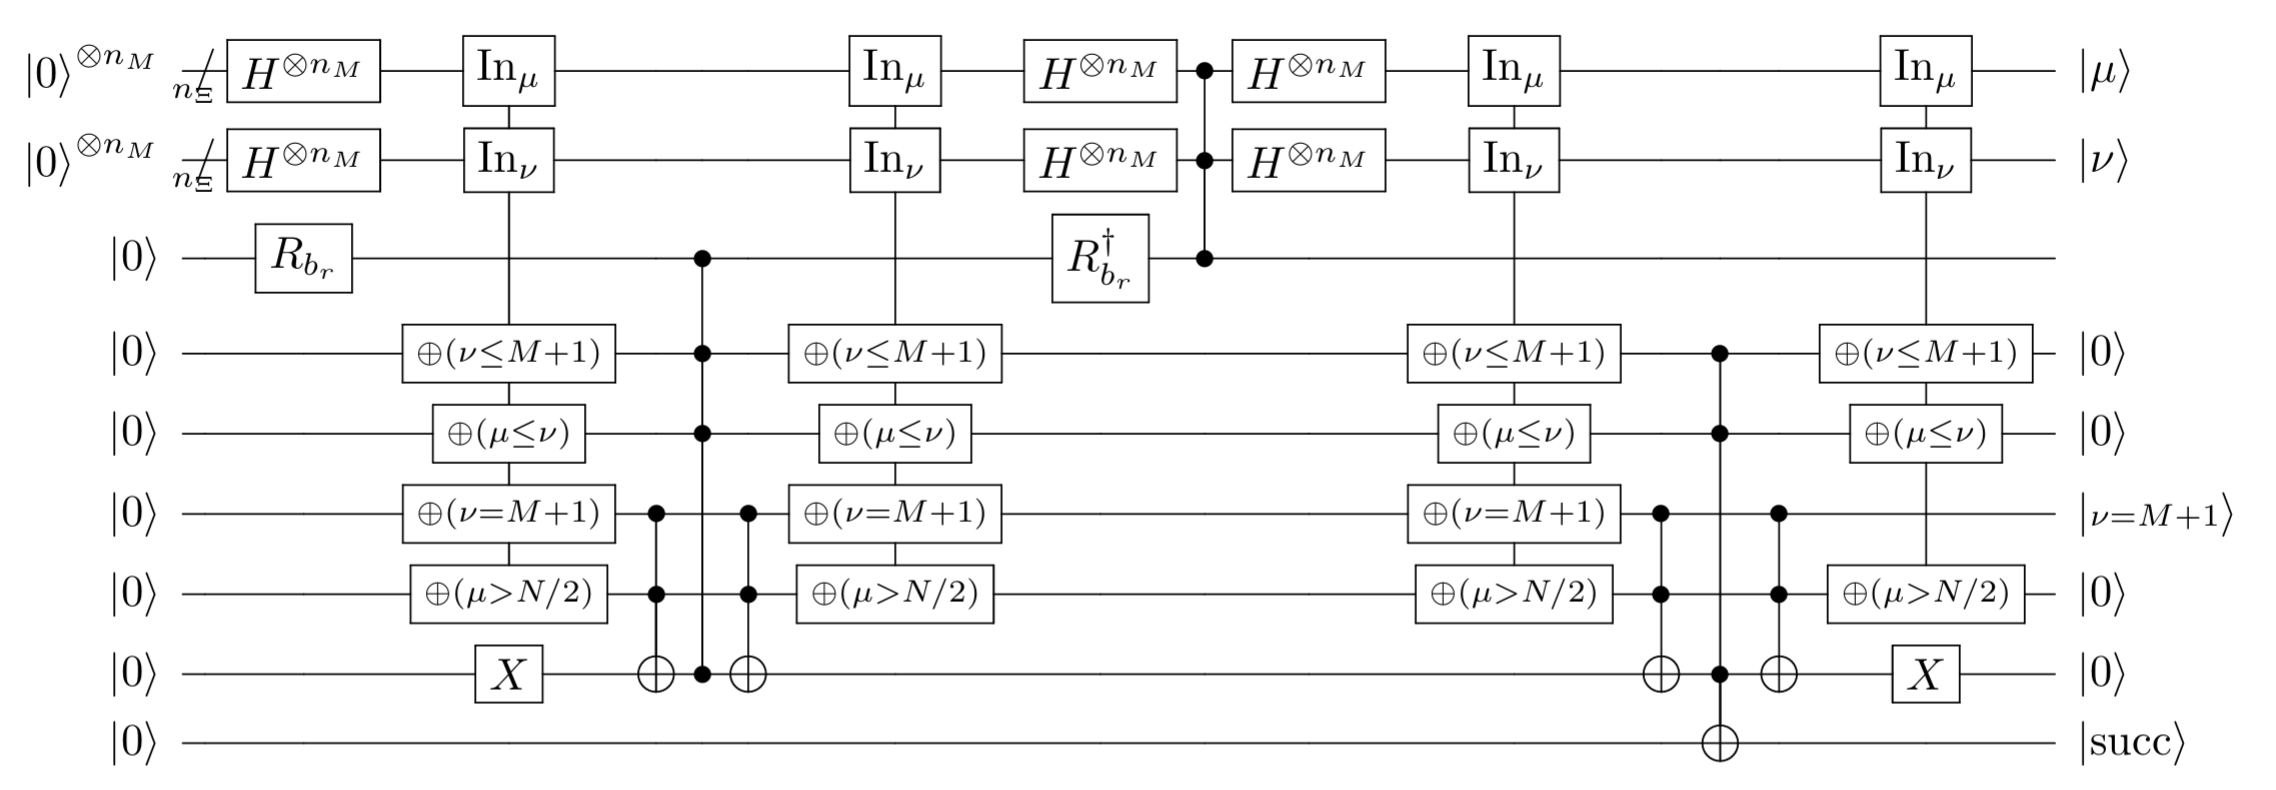

In [6]:
@qperm
def assign_aux(
    mu: QNum[n_mn],
    nu: QNum[n_mn],
    aux1: Output[QBit],
    aux2: Output[QBit],
    aux3: Output[QBit],
    aux4: Output[QBit],
) -> None:
    assign(nu <= m, aux1)
    assign(mu <= nu, aux2)
    assign(mu > n_mn / 2, aux3)
    assign(1, aux4)


@qfunc
def create_equal_superposition(ell: ELL) -> None:
    aux1 = QBit()
    aux2 = QBit()
    aux3 = QBit()
    aux4 = QBit()
    apply_to_all(H, ell.mu)
    apply_to_all(H, ell.nu)
    within_apply(
        within=lambda: (
            RY(R_BR, ell.r_br),
            inplace_xor(ell.nu == m + 1, ell.m1),
            assign_aux(ell.mu, ell.nu, aux1, aux2, aux3, aux4),
            CCX([ell.m1, aux3], aux4),
        ),
        apply=lambda: control([aux1, aux2, aux4], lambda: Z(ell.r_br)),
    )
    within_apply(
        within=lambda: (
            apply_to_all(H, ell.mu),
            apply_to_all(H, ell.nu),
        ),
        apply=lambda: control([ell.mu, ell.nu], lambda: Z(ell.r_br)),
    ),
    inplace_xor(ell.nu == m + 1, ell.m1)
    within_apply(
        within=lambda: (
            assign_aux(ell.mu, ell.nu, aux1, aux2, aux3, aux4),
            CCX([ell.m1, aux3], aux4),
        ),
        apply=lambda: control([aux1, aux2, aux4], lambda: X(ell.succ)),
    )


@qfunc
def main(ell: Output[ELL]):
    allocate(ell)
    create_equal_superposition(ell)


qprog_prepare_part1 = synthesize(main)

In [7]:
def print_qprog_stats(qprog: QuantumProgram) -> None:
    print(f"Total number of qubits is {qprog.data.width}")
    print(f"Total depth is {qprog.transpiled_circuit.depth}")

In [8]:
print_qprog_stats(qprog_prepare_part1)
show(qprog_prepare_part1)

Total number of qubits is 82
Total depth is 3842
Quantum program link: https://platform.classiq.io/circuit/36pzAyiSqMFc6yacBPxwpcme00w


## Prepare - Part 2
![prepare_2](images/prepare_2.png)


In [9]:
def in_uncontrolled(x: QArray[QBit], length: int, table: Iterator[QCallable]) -> None:
    if length == 1:
        raise NotImplementedError
    half = 2 ** ((length - 1).bit_length() - 1)
    within_apply(
        within=lambda: X(x[0]),
        apply=lambda: in_iteration(x[0], x, 1, half, table),
    )
    in_iteration(x[0], x, 1, length - half, table)


@qperm
def shift_right(x: Const[QNum], y: Output[QNum]) -> None:
    lsb = QBit()
    msbs = QNum("msbs", x.size - 1, False, 0)
    within_apply(
        within=lambda: bind(x, [msbs, lsb]),
        apply=lambda: assign(msbs, y),
    )


@qperm
def s_arithmetic(nu: Const[QNum], mu: Const[QNum], s: QNum) -> None:
    half_nu = QNum()
    within_apply(
        within=lambda: shift_right(nu, half_nu),
        apply=lambda: inplace_xor(nu * (half_nu + 1) + mu, s),
    )


@qperm
def single_qrom_access(
    ctrl: Const[QBit], target: QArray[QBit], data: CArray[CBool]
) -> None:
    repeat(data.len, lambda i: if_(data[i], lambda: CX(ctrl, target[i])))


def _yield_s(ell: ELL) -> Iterator[QCallable]:
    for i in range(m):
        yield lambda ctrl: (
            single_qrom_access(ctrl, ell.mu_alt, MU_ALT[i]),
            single_qrom_access(ctrl, ell.nu_alt, NU_ALT[i]),
            single_qrom_access(ctrl, ell.keep, KEEP[i]),
            single_qrom_access(ctrl, ell.theta, [THETA[i]]),
        )


@qperm
def _swap(state1: QArray[QBit], state2: QArray[QBit]) -> None:
    repeat(state1.len, lambda i: SWAP(state1[i], state2[i]))


@qperm
def in_s(ell: ELL) -> None:
    array_cast(ell.s, lambda s: in_uncontrolled(s, m, _yield_s(ell)))


@qfunc
def prepare_after_equal_superposition(ell: ELL) -> None:
    aux = QBit()
    s_arithmetic(ell.nu, ell.mu, ell.s)
    apply_to_all(H, ell.sigma)
    in_s(ell)
    within_apply(
        within=lambda: assign(ell.keep < ell.sigma, aux),
        apply=lambda: (
            CZ(ell.theta_alt, aux),
            within_apply(
                within=lambda: X(aux),
                apply=lambda: CZ(ell.theta, aux),
            ),
            control(aux, lambda: _swap(ell.mu, ell.mu_alt)),
            control(aux, lambda: _swap(ell.nu, ell.nu_alt)),
        ),
    ),
    H(ell.aux)
    # Q: Why don't we have control strings?
    within_apply(
        within=lambda: X(ell.m1),
        apply=lambda: control([ell.aux, ell.m1], lambda: _swap(ell.mu, ell.nu)),
    )


@qfunc
def main(ell: Output[ELL]):
    allocate(ell)
    prepare_after_equal_superposition(ell)


qprog_prepare_part2 = synthesize(main)

In [10]:
print_qprog_stats(qprog_prepare_part2)
show(qprog_prepare_part2)

Total number of qubits is 92
Total depth is 5023
Quantum program link: https://platform.classiq.io/circuit/36pzJPfsNDdGCbBap1mXDZ9yhwt


## Prepare summary

In [11]:
@qfunc
def prepare(ell: ELL) -> None:
    create_equal_superposition(ell)
    prepare_after_equal_superposition(ell)

# Select
![select](images/select.png)


In [12]:
def _yield_qrom(target: QVar, data: list[bool]) -> Iterator[QCallable]:
    for i in range(len(data)):
        yield lambda ctrl: single_qrom_access(ctrl, target, data[i])


@qfunc
def pauli_x_basis(q: QBit) -> None:
    H(q)


@qfunc
def pauli_y_basis(q: QBit) -> None:
    SDG(q)
    H(q)


@qperm
def _crzz(theta: CReal, ctrl: Const[QBit], target: Const[QArray[QBit, 2]]) -> None:
    within_apply(
        within=lambda: CX(target[0], target[1]),
        apply=lambda: CRZ(theta, ctrl, target[1]),
    )


@qperm
def digital_rotation(rot: Const[QArray], qs: Const[QArray[QBit, 2]]) -> None:
    repeat(rot.len, lambda i: _crzz(2 ** (-i) * pi / 2**rot.len, rot[i], qs))


@qfunc
def controlled_basis_change(rot: Const[QArray[QNum]], state: QArray[QBit]) -> None:
    repeat(
        rot.len - 1,
        lambda i: (
            within_apply(
                within=lambda: (
                    pauli_x_basis(state[i]),
                    pauli_y_basis(state[i + 1]),
                ),
                apply=lambda: digital_rotation(rot[i], [state[i], state[i + 1]]),
            ),
            within_apply(
                within=lambda: (
                    pauli_x_basis(state[i + 1]),
                    pauli_y_basis(state[i]),
                ),
                apply=lambda: invert(
                    lambda: digital_rotation(rot[i], [state[i], state[i + 1]])
                ),
            ),
        ),
    )


def in_controlled(
    ctrl: QBit, x: QArray[QBit], length: int, table: Iterator[QCallable]
) -> None:
    in_iteration(ctrl, x, 0, length, table)


@qperm
def in_mu(mu: QArray[QBit], m1: QBit, rot: QArray[QNum]) -> None:
    in_controlled(m1, mu, m, _yield_qrom(rot, ROT_MU))


@qperm
def in_nu(nu: QArray[QBit], rot: QArray[QNum]) -> None:
    in_uncontrolled(nu, m, _yield_qrom(rot, ROT_NU))


@qperm
def _ciz(ctrl: Const[QBit], target: Const[QBit]) -> None:
    S(ctrl)
    CZ(ctrl, target)


@qperm
def _cciz(ctrl1: Const[QBit], ctrl2: Const[QBit], target: Const[QBit]) -> None:
    control(ctrl1, lambda: S(ctrl2))
    control([ctrl1, ctrl2], lambda: Z(target))


@qfunc
def select(ell: ELL, psi: PSI) -> None:
    rot = QArray("rot", QNum[n_beth], N_UD)
    within_apply(
        within=lambda: (
            allocate(rot),
            in_mu(ell.mu, ell.m1, rot),
            control(psi.plus1, lambda: _swap(psi.down, psi.up)),
            invert(lambda: controlled_basis_change(rot, psi.down)),
        ),
        apply=lambda: _ciz(ell.succ, psi.down[0]),
    )
    within_apply(
        within=lambda: (
            allocate(rot),
            in_nu(ell.nu, rot),
            control(psi.plus2, lambda: _swap(psi.down, psi.up)),
            invert(lambda: controlled_basis_change(rot, psi.down)),
        ),
        # Q: Why don't we have control strings?
        apply=lambda: within_apply(
            within=lambda: X(ell.m1),
            apply=lambda: _cciz(ell.succ, ell.m1, psi.down[0]),
        ),
    )


@qfunc
def main(ell: Output[ELL], psi: Output[PSI]):
    allocate(ell)
    allocate(psi)
    select(ell, psi)


qprog_select = synthesize(main)

In [13]:
print_qprog_stats(qprog_select)
show(qprog_select)

Total number of qubits is 107
Total depth is 3151
Quantum program link: https://platform.classiq.io/circuit/36pzUmQOu8zcaiL1MoiDQkatOHv


# Walk Operator
![walk](images/walk.png)
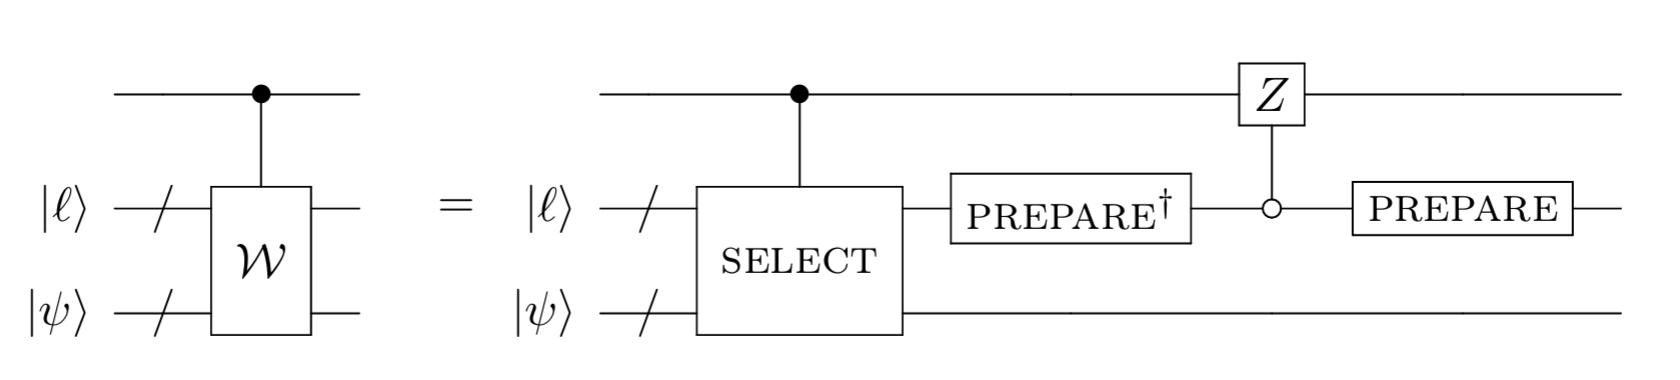

In [14]:
@qfunc
def controlled_reflect(ctrl: QBit, ell: ELL) -> None:
    within_apply(
        within=lambda: invert(lambda: prepare(ell)),
        # Q: Why don't we have good control logic? This is a basic reflection.
        apply=lambda: within_apply(
            within=lambda: (
                X(ctrl),
                apply_to_all(X, ell),
            ),
            apply=lambda: array_cast(ell, lambda _ell: control(_ell, lambda: Z(ctrl))),
        ),
    )


def yield_w(ell: ELL, psi: PSI) -> Iterator[QCallable]:
    yield lambda aux: controlled_reflect(aux, ell)
    while True:
        yield lambda aux: (select(ell, psi), controlled_reflect(aux, ell))

# Repeated Walk with Recursion

In [15]:
@qfunc
def init_psi(psi: PSI) -> None:
    H(psi.plus1)
    H(psi.plus2)


@qfunc
def prepare_xi(x: QArray[QBit]) -> None:
    inplace_prepare_amplitudes(SINE_AMPLITUDES, 0, x)


@qfunc
def in_t(t: QArray[QBit], ell: ELL, psi: PSI) -> None:
    in_uncontrolled(t, t_max, yield_w(ell, psi))


@qfunc
def main(t: Output[QArray[QBit, n_t]], ell: Output[ELL], psi: Output[PSI]) -> None:
    allocate(ell)
    allocate(t)
    allocate(psi)
    prepare_xi(t)
    init_psi(psi)
    in_t(t, ell, psi)
    invert(lambda: qft(t))


print(f"{N_EPSILON=}")
print(f"{N_UD=}")

N_EPSILON=4
N_UD=3


In [16]:
qmod = create_model(main)
qmod = set_preferences(
    qmod,
    Preferences(
        transpilation_option=TranspilationOption.NONE,
        optimization_level=OptimizationLevel.NONE,
        debug_mode=False,
        timeout_seconds=1800,
    ),
)

In [17]:
qprog = synthesize(qmod)

In [18]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pztXgMc7Ucpgw4g1QZ9MbHLZ0


In [19]:
print(f"Total number of qubits is {qprog.data.width=}")

Total number of qubits is qprog.data.width=114
